In [55]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from dataloader import DataLoader
from PIL import Image
from _graphutils import GraphUtils
from _plotutils import PlotUtils
from kernels.wlkernel import WLKernel
from kernels.shortestpathkernel import ShortestPathKernel
from kernels.randomwalkkernel import RandomWalkKernel
from kernels.labelhasher import LabelHasher
from __PIPELINES import Pipeline
from localmetric import LocalMetrics
from sklearn.kernel_ridge import KernelRidge
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import LeaveOneOut

In [48]:
dl = DataLoader("../eyelink_data")
imgs = dl.get_annotated_images()
PLOT = True
img = imgs[3]
aois = dl.get_image_aois(image=img)


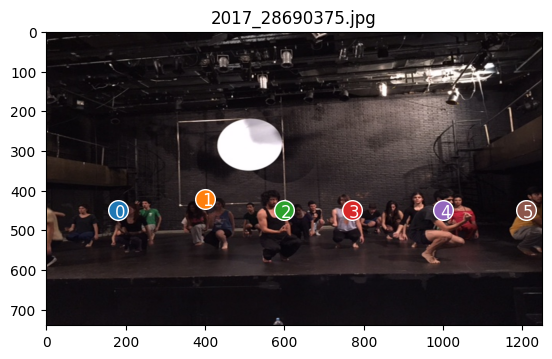

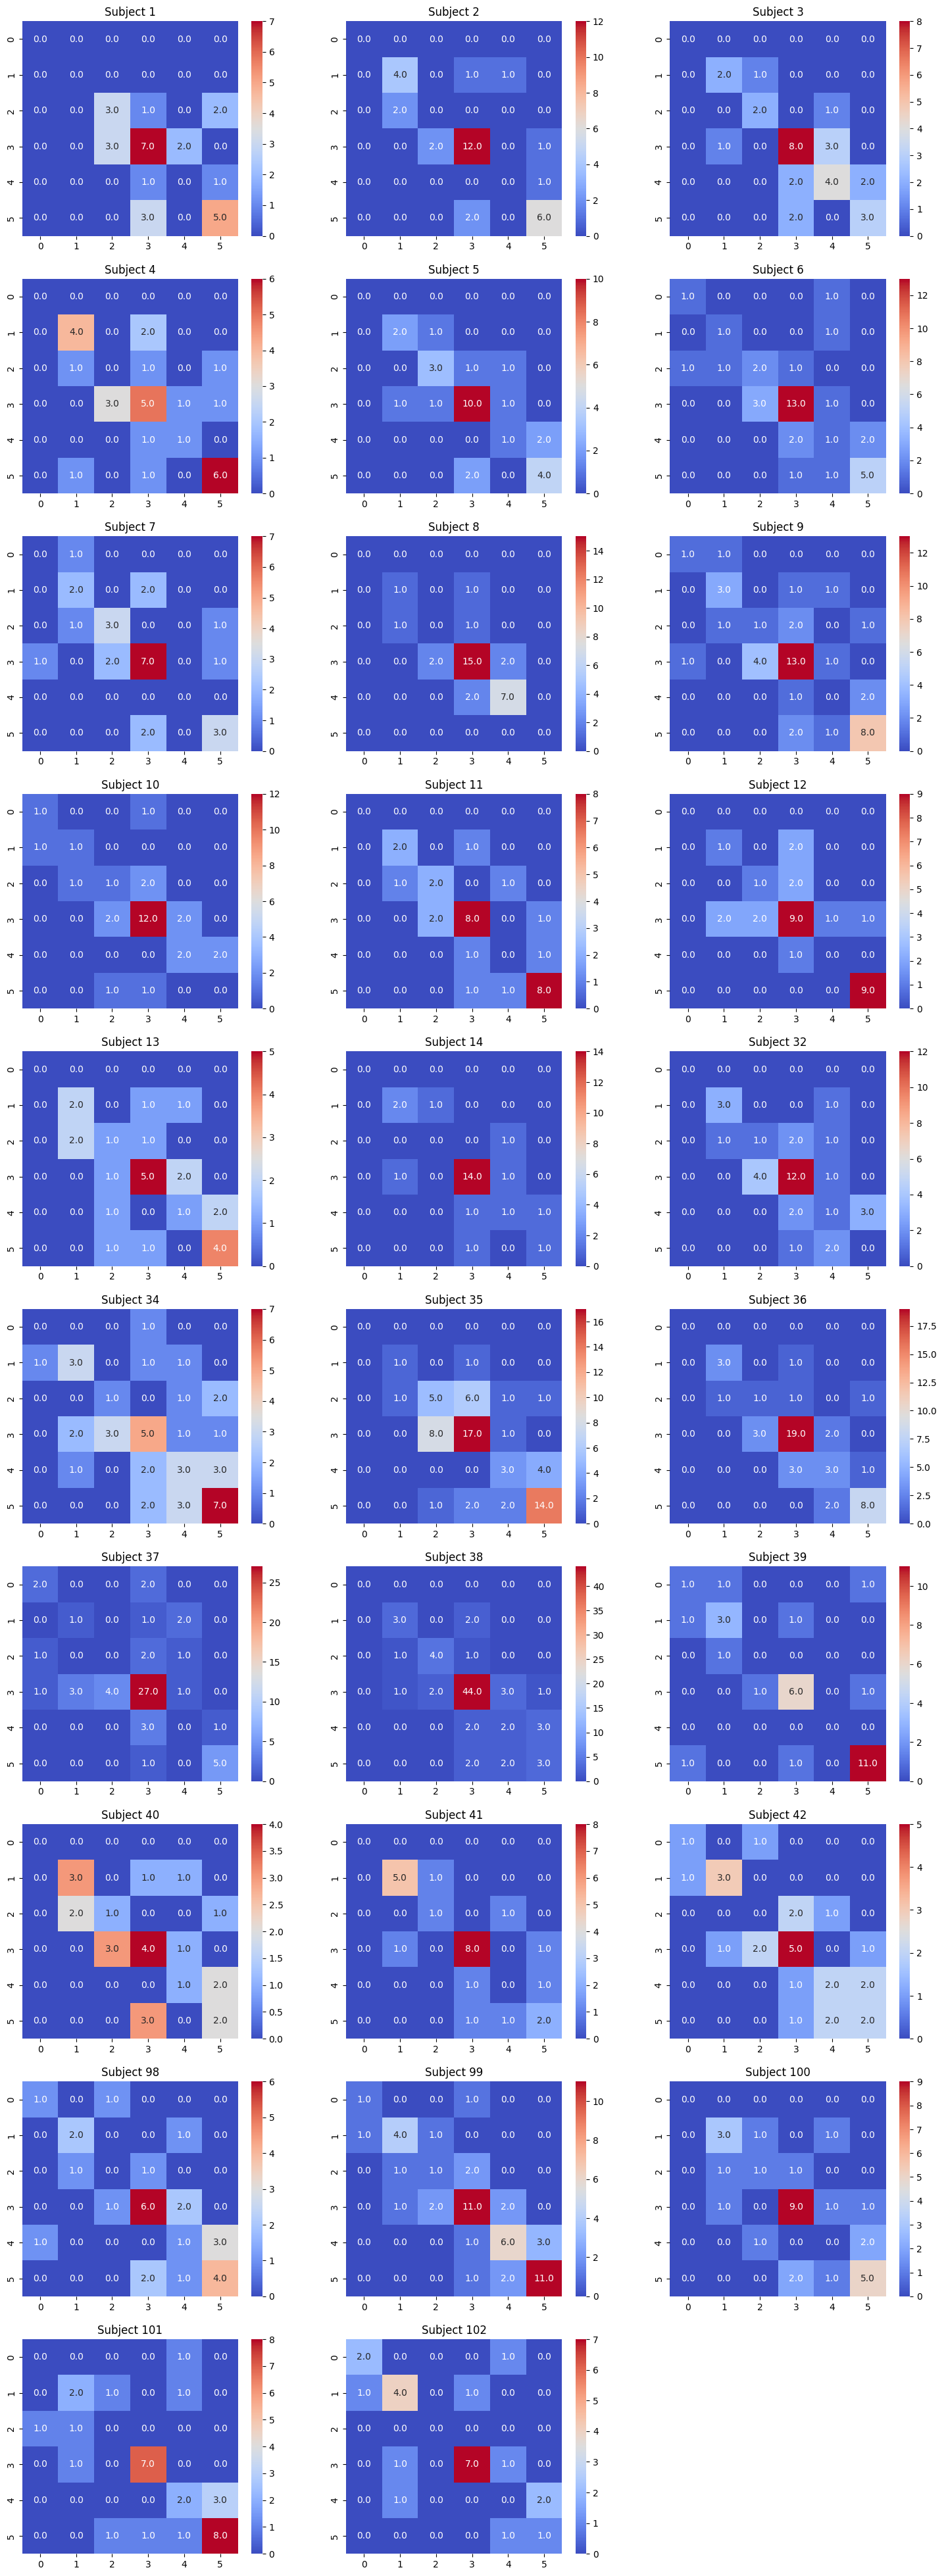

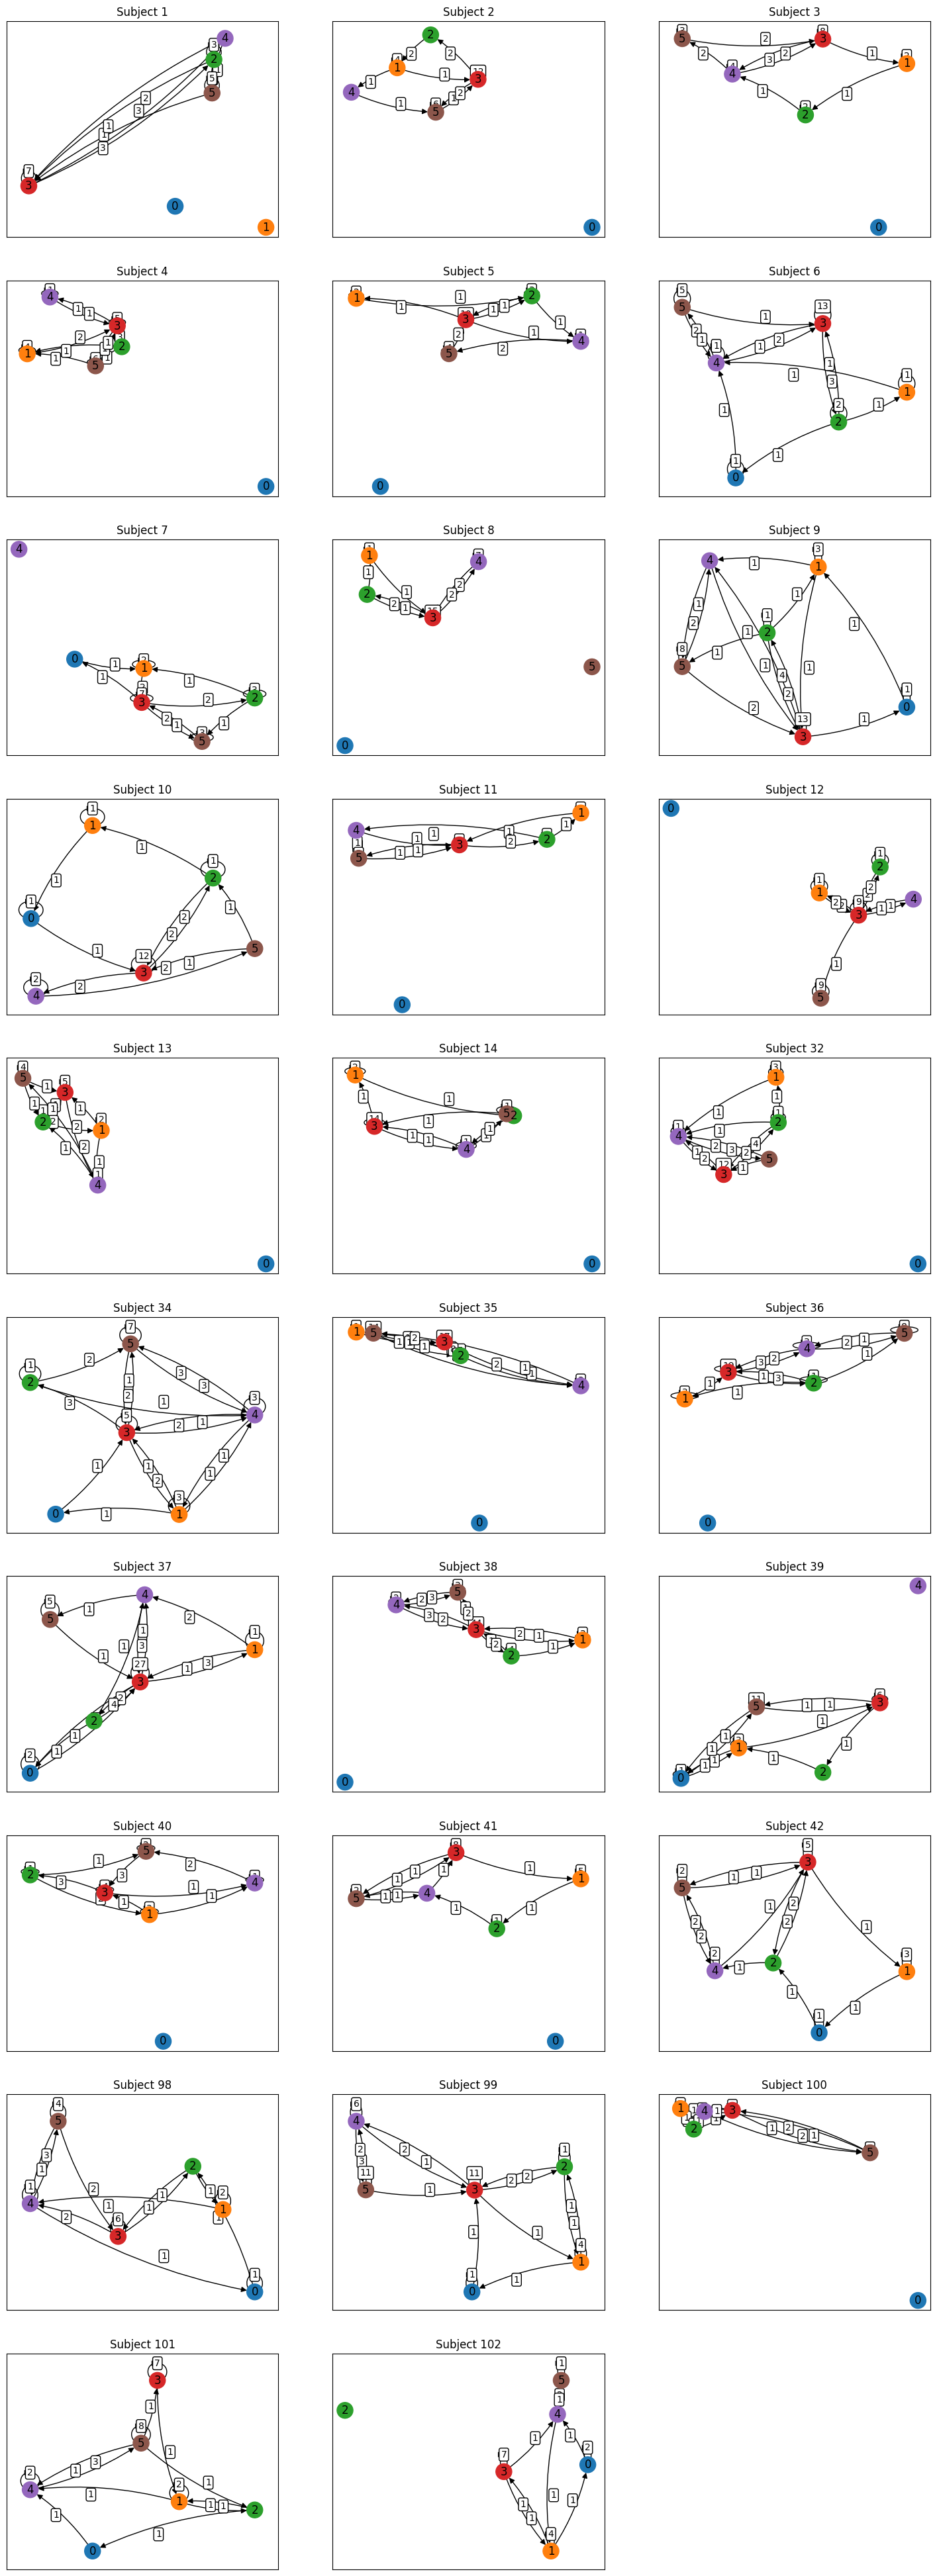

In [64]:
aois = dl.get_image_aois(img)
img_file = dl.get_image(img)
PlotUtils.plot_aois(aois, img, image=img_file)
trials = dl.get_image_trials(img)
trial_numbers = dl.get_image_trials(img, False)
answer_dfs = dl.get_image_answers(img)
answers = {subject: answer_dfs[subject].query(f"trial == {trial_numbers[subject]}")["response"].item() for subject in trials.keys()}

trials_clustered = {subject: GraphUtils.cluster_to_aois(trial, aois) for (subject, trial) in trials.items()}


matrices = {subject: GraphUtils.transition_matrix(trial, aois=aois) for (subject, trial) in trials_clustered.items()}
if PLOT:
    PlotUtils.wrap_dict_plot(matrices, n_wrap=3, plotting_function=PlotUtils.heatmap, title="Subject")


graphs = {subject: GraphUtils.transition_matrix_to_graph(matrix) for (subject, matrix) in matrices.items()}
if PLOT:
    PlotUtils.wrap_dict_plot(graphs, n_wrap=3, plotting_function=PlotUtils.draw, title="Subject")



/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


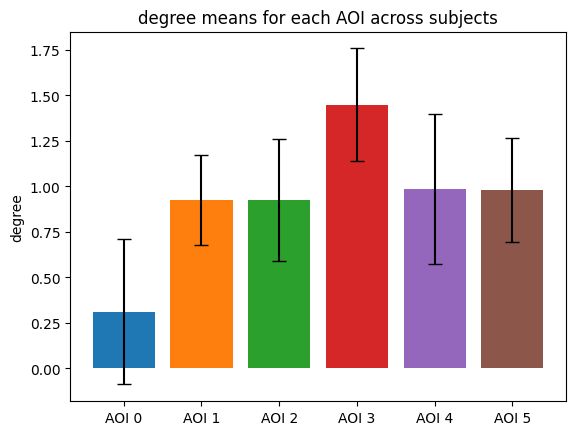

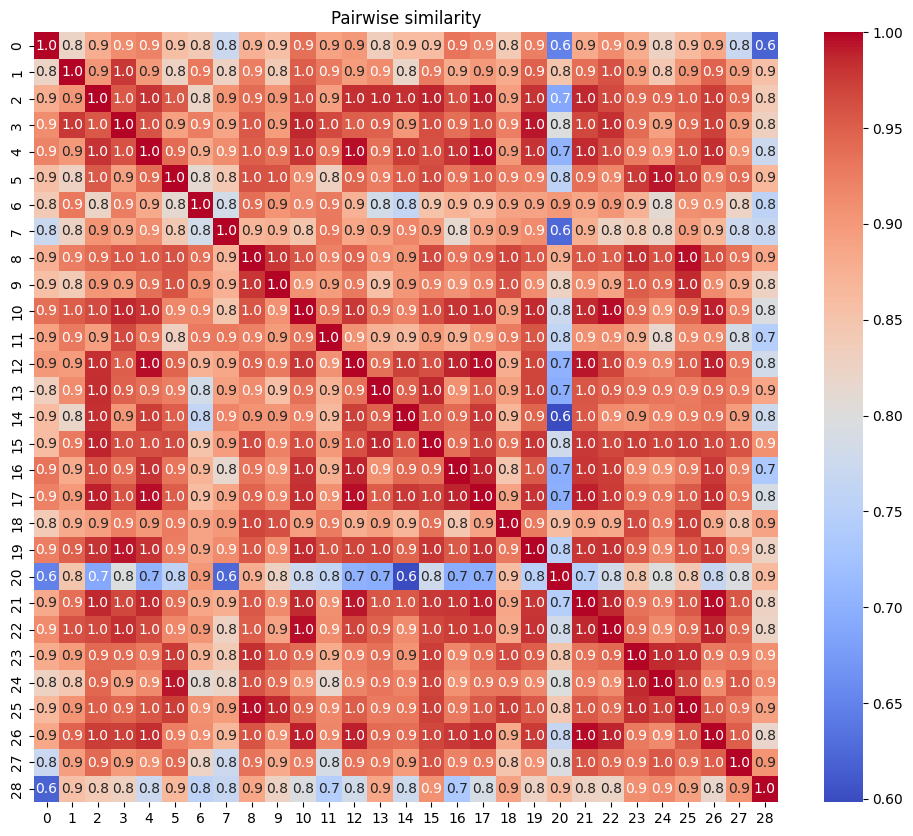

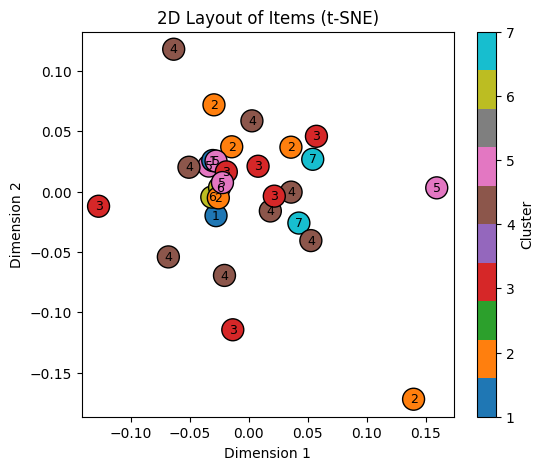

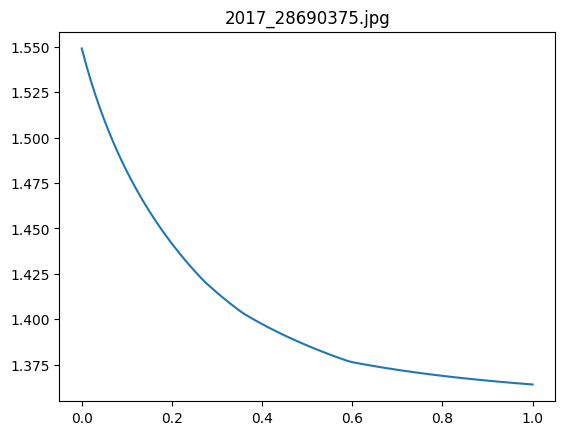

In [ ]:
degree = {subject: LocalMetrics.degree_centrality(G) for subject, G in graphs.items()}
PlotUtils.centrality_bar_plot(degree, "Degree centrality")

subjects_order =list(degree.keys())
K_matrix = np.zeros(shape=(len(degree), len(degree)))
for i, (subject1, degree1) in enumerate(degree.items()):
    for j, (subject2, degree2) in enumerate(degree.items()):
        K = np.dot(degree1, degree2) / (np.linalg.norm(degree1) * np.linalg.norm(degree2))
        K_matrix[i][j] = K

PlotUtils.heatmap(K_matrix, title="Pairwise similarity")


D_matrix = 1 - K_matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_2d = mds.fit_transform(D_matrix)

labels = np.array([answers[subject] for subject in subjects_order])

# if PLOT:        
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels,              
    cmap='tab10',          
    s=250,                 
    edgecolor='k'
)
for i, label in enumerate(labels):
    plt.text(X_2d[i,0], X_2d[i,1], str(label),
            color='black', fontsize=9,
            ha='center', va='center')
    
plt.title("2D Layout of Items (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Cluster')
plt.show()


# LEAVE ONE OUT CROSS VALIDATION
results = []
alphas = np.arange(0, 1.01, 0.01)
for alpha in alphas:
    loocv = LeaveOneOut()
    y_true, y_pred = [], []
    for train_index, test_index in loocv.split(K_matrix):
        K_train = K_matrix[np.ix_(train_index, train_index)]
        K_test = K_matrix[np.ix_(test_index, train_index)]
        model = KernelRidge(alpha=alpha, kernel="precomputed")
        model.fit(K_train, labels[train_index])
                    
        y_hat = model.predict(K_test)
        y_true.append(float(labels[test_index][0]))
        y_pred.append(float(y_hat[0]))

    # evaluate
    #for true, pred in zip(y_true, y_pred):
    #    print(f"{true} <> {pred}")

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    # optional: round predictions back to [1,7]
    y_pred_rounded = np.clip(np.rint(y_pred), 1, 7)
    acc = np.mean(np.array(y_pred_rounded) == np.array(y_true))
    results.append(mae)

fig, ax = plt.subplots(1,1)
ax.set(title=img)
ax.plot(alphas, results)


/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


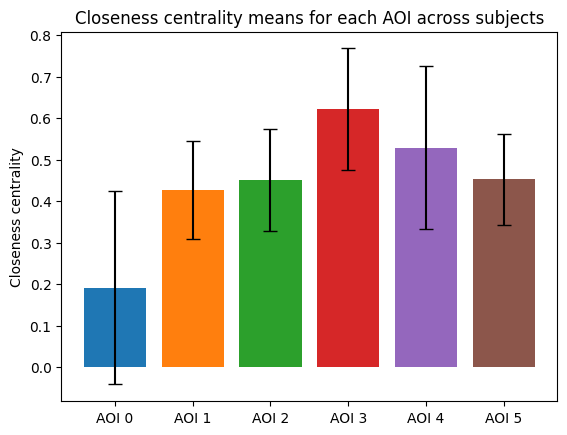

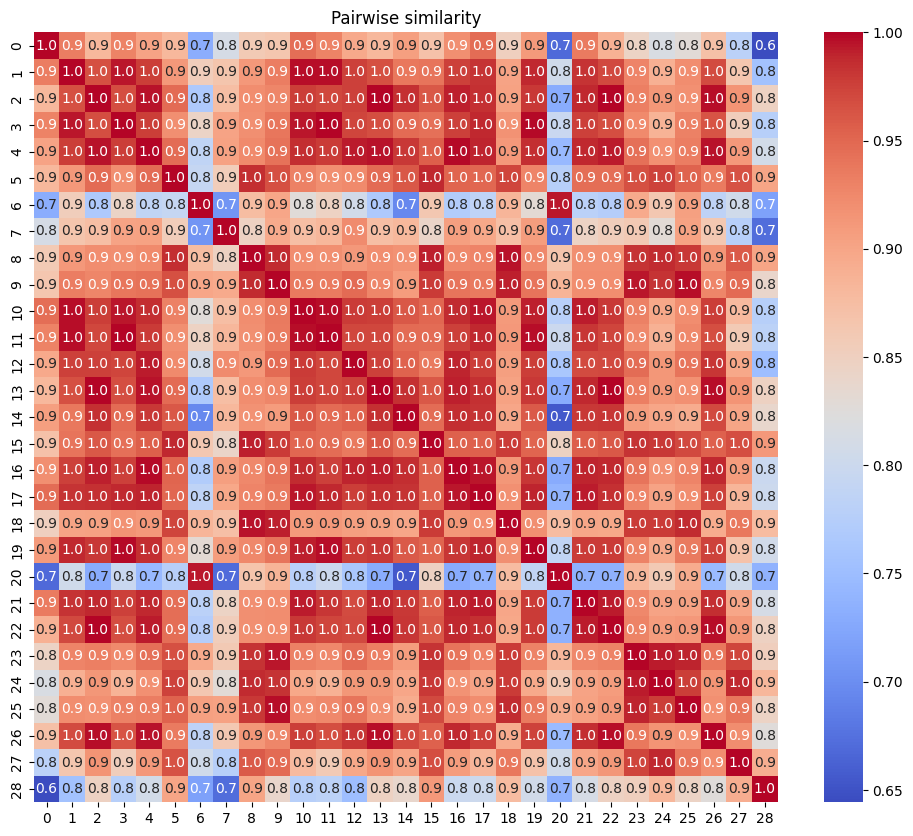

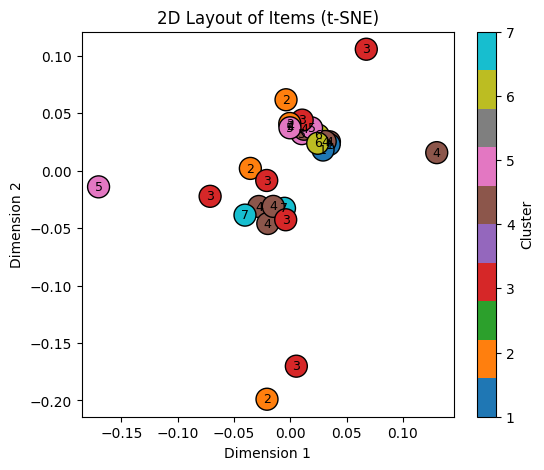

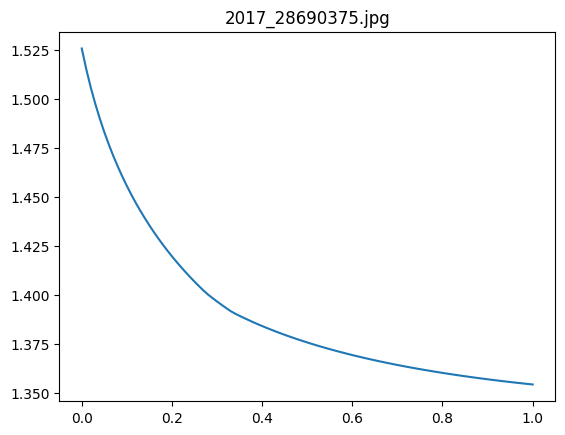

In [65]:
closeness = {subject: LocalMetrics.closeness_centrality(G) for subject, G in graphs.items()}
PlotUtils.centrality_bar_plot(closeness, "Closeness centrality")

subjects_order =list(closeness.keys())
K_matrix = np.zeros(shape=(len(closeness), len(closeness)))
for i, (subject1, closeness1) in enumerate(closeness.items()):
    for j, (subject2, closeness2) in enumerate(closeness.items()):
        K = np.dot(closeness1, closeness2) / (np.linalg.norm(closeness1) * np.linalg.norm(closeness2))
        K_matrix[i][j] = K

PlotUtils.heatmap(K_matrix, title="Pairwise similarity")


D_matrix = 1 - K_matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_2d = mds.fit_transform(D_matrix)

labels = np.array([answers[subject] for subject in subjects_order])

# if PLOT:        
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels,              
    cmap='tab10',          
    s=250,                 
    edgecolor='k'
)
for i, label in enumerate(labels):
    plt.text(X_2d[i,0], X_2d[i,1], str(label),
            color='black', fontsize=9,
            ha='center', va='center')
    
plt.title("2D Layout of Items (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Cluster')
plt.show()


# LEAVE ONE OUT CROSS VALIDATION
results = []
alphas = np.arange(0, 1.01, 0.01)
for alpha in alphas:
    loocv = LeaveOneOut()
    y_true, y_pred = [], []
    for train_index, test_index in loocv.split(K_matrix):
        K_train = K_matrix[np.ix_(train_index, train_index)]
        K_test = K_matrix[np.ix_(test_index, train_index)]
        model = KernelRidge(alpha=alpha, kernel="precomputed")
        model.fit(K_train, labels[train_index])
                    
        y_hat = model.predict(K_test)
        y_true.append(float(labels[test_index][0]))
        y_pred.append(float(y_hat[0]))

    # evaluate
    #for true, pred in zip(y_true, y_pred):
    #    print(f"{true} <> {pred}")

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    # optional: round predictions back to [1,7]
    y_pred_rounded = np.clip(np.rint(y_pred), 1, 7)
    acc = np.mean(np.array(y_pred_rounded) == np.array(y_true))
    results.append(mae)

fig, ax = plt.subplots(1,1)
ax.set(title=img)
ax.plot(alphas, results)


/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


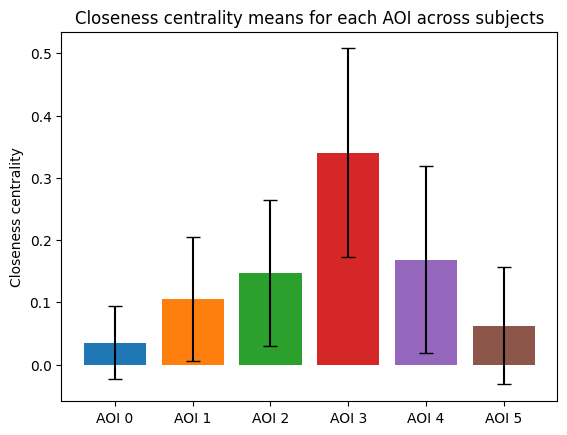

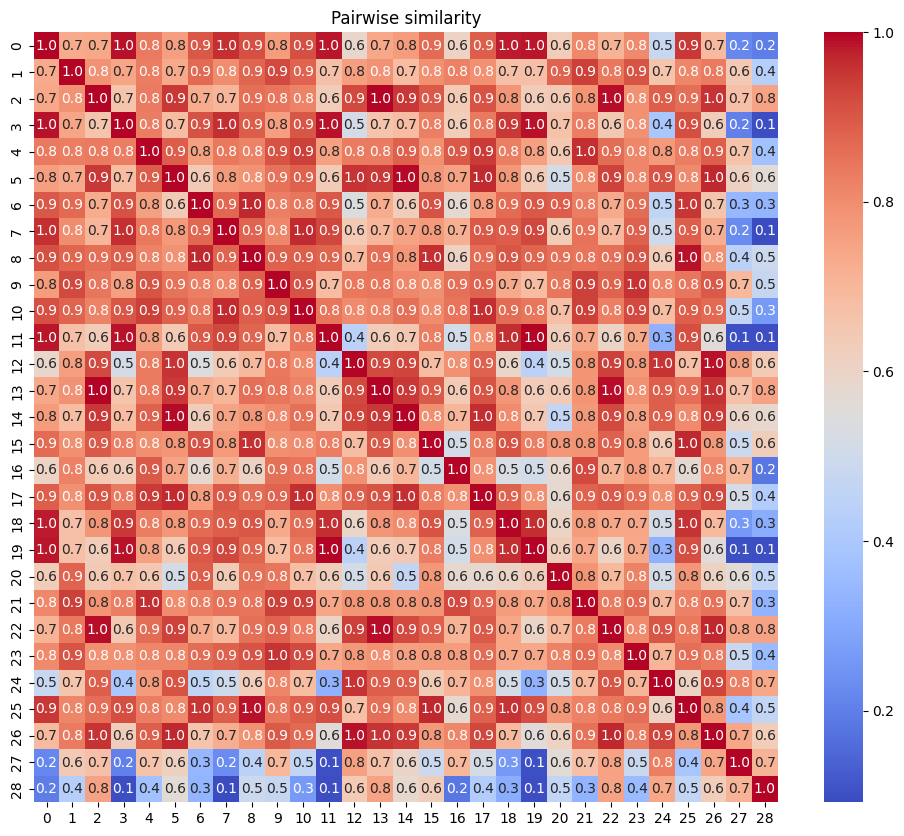

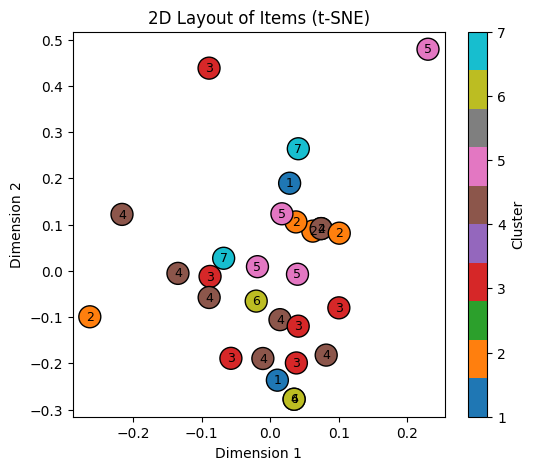

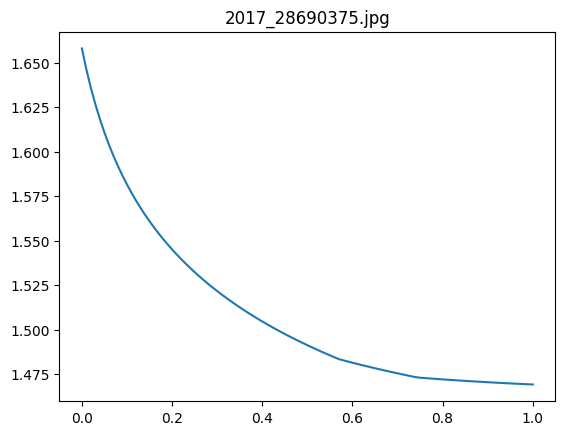

In [ ]:
betweenness = {subject: LocalMetrics.betweenness_centrality(G) for subject, G in graphs.items()}
PlotUtils.centrality_bar_plot(betweenness, "Closeness centrality")

subjects_order =list(betweenness.keys())
K_matrix = np.zeros(shape=(len(betweenness), len(betweenness)))
for i, (subject1, betweenness1) in enumerate(betweenness.items()):
    for j, (subject2, betweenness2) in enumerate(betweenness.items()):
        K = np.dot(betweenness1, betweenness2) / (np.linalg.norm(betweenness1) * np.linalg.norm(betweenness2))
        K_matrix[i][j] = K

PlotUtils.heatmap(K_matrix, title="Pairwise similarity")


D_matrix = 1 - K_matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_2d = mds.fit_transform(D_matrix)

labels = np.array([answers[subject] for subject in subjects_order])

# if PLOT:        
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels,              
    cmap='tab10',          
    s=250,                 
    edgecolor='k'
)
for i, label in enumerate(labels):
    plt.text(X_2d[i,0], X_2d[i,1], str(label),
            color='black', fontsize=9,
            ha='center', va='center')
    
plt.title("2D Layout of Items (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Cluster')
plt.show()


# LEAVE ONE OUT CROSS VALIDATION
results = []
alphas = np.arange(0, 1.01, 0.01)
for alpha in alphas:
    loocv = LeaveOneOut()
    y_true, y_pred = [], []
    for train_index, test_index in loocv.split(K_matrix):
        K_train = K_matrix[np.ix_(train_index, train_index)]
        K_test = K_matrix[np.ix_(test_index, train_index)]
        model = KernelRidge(alpha=alpha, kernel="precomputed")
        model.fit(K_train, labels[train_index])
                    
        y_hat = model.predict(K_test)
        y_true.append(float(labels[test_index][0]))
        y_pred.append(float(y_hat[0]))

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    y_pred_rounded = np.clip(np.rint(y_pred), 1, 7)
    acc = np.mean(np.array(y_pred_rounded) == np.array(y_true))
    results.append(mae)

fig, ax = plt.subplots(1,1)
ax.set(title=img)
ax.plot(alphas, results)


/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


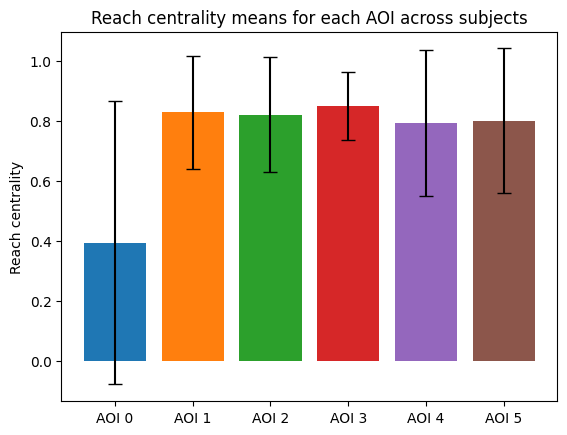

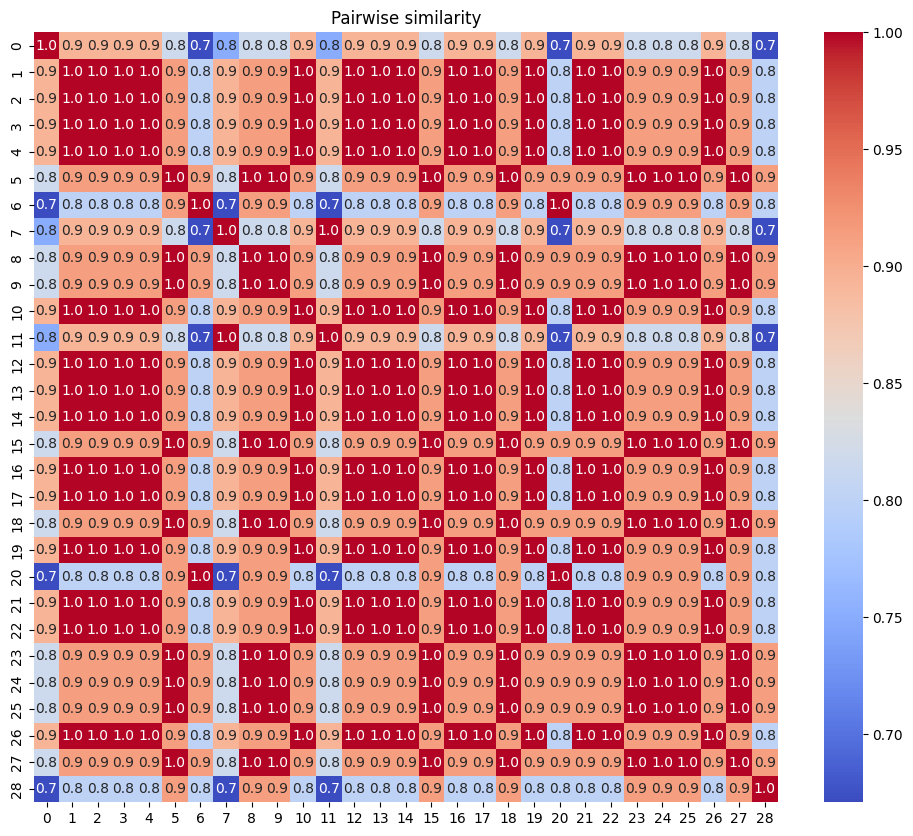

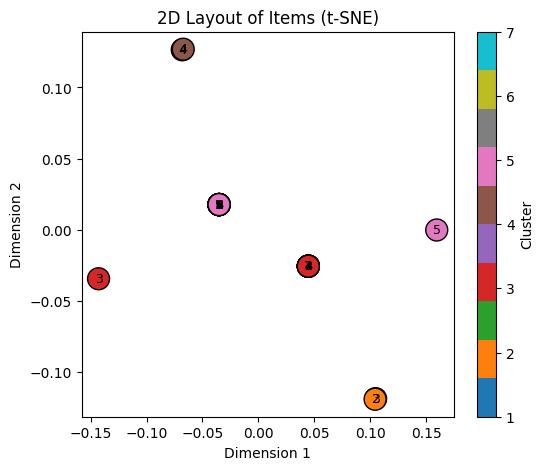

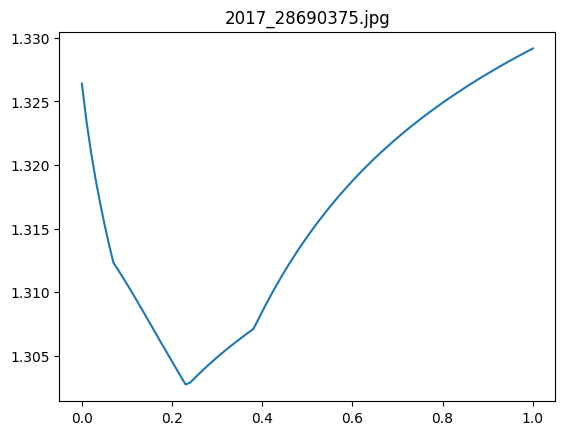

In [ ]:
reach = {subject: LocalMetrics.reach_centrality(G) for subject, G in graphs.items()}
PlotUtils.centrality_bar_plot(reach, "Reach centrality")

subjects_order =list(reach.keys())
K_matrix = np.zeros(shape=(len(reach), len(reach)))
for i, (subject1, reach1) in enumerate(reach.items()):
    for j, (subject2, reach2) in enumerate(reach.items()):
        K = np.dot(reach1, reach2) / (np.linalg.norm(reach1) * np.linalg.norm(reach2))
        K_matrix[i][j] = K

PlotUtils.heatmap(K_matrix, title="Pairwise similarity")


D_matrix = 1 - K_matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_2d = mds.fit_transform(D_matrix)

labels = np.array([answers[subject] for subject in subjects_order])

# if PLOT:        
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels,              
    cmap='tab10',          
    s=250,                 
    edgecolor='k'
)
for i, label in enumerate(labels):
    plt.text(X_2d[i,0], X_2d[i,1], str(label),
            color='black', fontsize=9,
            ha='center', va='center')
    
plt.title("2D Layout of Items (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Cluster')
plt.show()


# LEAVE ONE OUT CROSS VALIDATION
results = []
alphas = np.arange(0, 1.01, 0.01)
for alpha in alphas:
    loocv = LeaveOneOut()
    y_true, y_pred = [], []
    for train_index, test_index in loocv.split(K_matrix):
        K_train = K_matrix[np.ix_(train_index, train_index)]
        K_test = K_matrix[np.ix_(test_index, train_index)]
        model = KernelRidge(alpha=alpha, kernel="precomputed")
        model.fit(K_train, labels[train_index])
                    
        y_hat = model.predict(K_test)
        y_true.append(float(labels[test_index][0]))
        y_pred.append(float(y_hat[0]))


    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    y_pred_rounded = np.clip(np.rint(y_pred), 1, 7)
    acc = np.mean(np.array(y_pred_rounded) == np.array(y_true))
    results.append(mae)

fig, ax = plt.subplots(1,1)
ax.set(title=img)
ax.plot(alphas, results)
